In [ ]:
import sys
import numpy as np
import numpy.random as rn
from numpy import linalg
sys.path.append('../..')
from examples.safe_PCE import *
import matplotlib.pyplot as plt
random.seed(10)
np.random.seed(10)
noise_arr = [0.33994760, 0.25363799, 0.31864008, 0.30796535, 0.33609112, 0.33084822, 0.31335413, 0.30405411, 0.34453611, 0.26760585]
# Constrauct safe policy with high entropy such that it encourages exploration for policy gradient approach
env = make_env(0.4)  
pi_s, u_s, v_s = LP(env)

In [2]:
# Implementation of Algorithm: Safe Policy Adaptation (sampling)
def rollout_trajectory(env, policy: np.ndarray, horizon=600):
    """
    Generate a trajectory of length T, following the given policy. 
    Returns the trajectory data needed for estimation.
    """
    nu0 = env.nu0
    trajectory = []
    
    # 1. Sample initial state
    s = rn.choice(env.n, p=nu0)
    
    for t in range(horizon):      
        # 2. Sample action from policy
        a = rn.choice(env.m, p=policy[s, :])
        
        # 3. Sample next state from dynamics (Black Box simulation)
        s_next = rn.choice(env.n, p=env.P[s, a, :]) 
        
        # 4. Get Reward and Cost
        c = env.Psi[s, a, 0]
        r = env.r[s, a]
        
        # Store tuple: (state, action, reward, cost)
        trajectory.append((s, a, r, c))
        
        s = s_next
        # Early termination at absorbing state
        if s == 45:
            # Fill remaining trajectory with absorbing state transitions
            # At absorbing state, action doesn't matter (use a=0), reward and cost are defined
            remaining_steps = horizon - t - 1
            if remaining_steps > 0:
                a_absorb = 0
                c_absorb = env.Psi[45, a_absorb, 0]
                r_absorb = env.r[45, a_absorb]
                absorbing_tuple = (45, a_absorb, r_absorb, c_absorb)
                trajectory.extend([absorbing_tuple] * remaining_steps)
            break
        
    return trajectory


def estimate_advantages_and_cost(env, policy, num_trajectories=100, horizon=600):
    """
    Monte-Carlo estimation of Advantages with correct handling of unvisited states.
    """
    n, m = env.n, env.m
    gamma = env.gamma
    
    Q_r_sum = np.zeros((n, m))
    Q_c_sum = np.zeros((n, m))
    N_sa = np.zeros((n, m))
    
    V_r_sum = np.zeros(n)
    V_c_sum = np.zeros(n)
    N_s = np.zeros(n)
    
    total_cost_estimates = []
    # Buffer stores (state, weight) to match discounted visitation distribution
    visited_states_buffer = [] 

    for _ in range(num_trajectories):
        traj = rollout_trajectory(env, policy, horizon)
        G_r, G_c = 0, 0
        
        # Backward pass
        for t in reversed(range(len(traj))):
            s, a, r, c = traj[t]
            G_r = r + gamma * G_r
            G_c = c + gamma * G_c
            
            Q_r_sum[s, a] += G_r
            Q_c_sum[s, a] += G_c
            N_sa[s, a] += 1
            
            V_r_sum[s] += G_r
            V_c_sum[s] += G_c
            N_s[s] += 1
            
            # Store state
            visited_states_buffer.append(s) 
            
            if t == 0:
                total_cost_estimates.append(G_c)

    # --- Compute Estimates ---
    
    # 1. Mask for visited pairs
    sa_mask = N_sa > 0
    s_mask = N_s > 0
    
    Q_r_hat = np.zeros((n, m))
    Q_c_hat = np.zeros((n, m))
    
    # Safe division
    Q_r_hat[sa_mask] = Q_r_sum[sa_mask] / N_sa[sa_mask]
    Q_c_hat[sa_mask] = Q_c_sum[sa_mask] / N_sa[sa_mask]
    
    V_r_hat = np.zeros(n)
    V_c_hat = np.zeros(n)
    V_r_hat[s_mask] = V_r_sum[s_mask] / N_s[s_mask]
    V_c_hat[s_mask] = V_c_sum[s_mask] / N_s[s_mask]
    
    # 2. Compute Advantage A(s,a) = Q(s,a) - V(s)
    # FIX: Initialize with 0.0 so unvisited actions have neutral advantage
    A_r_hat = np.zeros((n, m))
    A_c_hat = np.zeros((n, m))
    
    # Calculate raw difference
    raw_Ar = Q_r_hat - V_r_hat[:, None]
    raw_Ac = Q_c_hat - V_c_hat[:, None]
    
    # FIX: Only apply difference to visited pairs. Unvisited remain 0.0.
    A_r_hat[sa_mask] = raw_Ar[sa_mask]
    A_c_hat[sa_mask] = raw_Ac[sa_mask]
    
    J_c_hat = np.mean(total_cost_estimates)
    
    return A_r_hat, A_c_hat, J_c_hat, visited_states_buffer

def one_step_safe_adaptation(env, pi_init, num_trai=100, num_iter=30, lam = 0.2, lam_c= 0.2, beta = 1, delta=0.0):
    # num_iter: number of gradient steps and it is always safe and u is always 0, which means  gradient steps are not active. Therefore, even this nuumber is 10, it is more than enough.
    pi_s = pi_init.copy()
    gamma = env.gamma
    
    # 1. Get Estimates (with corrected Advantages)
    A_r_est, A_c_est, J_c_est, state_buffer = estimate_advantages_and_cost(env, pi_s, num_trai)

    # d'_i calculation [cite: 157]
    d_prime = (1 - gamma) * (env.b + delta - J_c_est)
    
    log_pi_s = np.log(np.clip(pi_s, 1e-10, None))
    u = 0.0
    
    for _ in range(num_iter):
        # Calculate eta 
        eta = lam + (1 - gamma) * (u * lam_c)
        
        # Calculate logits 
        # A_r_est and A_c_est are 0 for unvisited, preserving exploration
        adv_diff = A_r_est - u * A_c_est
        logits = adv_diff / eta
        
        # Softmax
        max_logits = np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits - max_logits)
        pi_u = pi_s * exp_logits
        pi_u = pi_u / np.sum(pi_u, axis=1, keepdims=True)
        
        # Gradient Estimation 
        if len(state_buffer) > 0:
            batch_size = len(state_buffer)
            # Sampling uniformly from buffer approximates discounted expectation if gamma ~ 1
            batch_states = rn.choice(state_buffer, size=batch_size)
            
            # Expected cost advantage E[A_c]
            E_a_Ac = np.sum(pi_u[batch_states] * A_c_est[batch_states], axis=1)
            
            # KL Divergence
            kl_div = np.sum(pi_u[batch_states] * (np.log(np.clip(pi_u[batch_states], 1e-10, None)) - log_pi_s[batch_states]), axis=1)
            
            avg_term = np.mean(E_a_Ac + (1 - gamma) * lam_c * kl_div)
            grad_L = d_prime - avg_term
            
            # Projected Gradient Descent 
            u = max(0.0, u - beta * grad_L)
            
    return pi_u

def multi_step_safe_adaptation(env, pi_s, max_iters = 100, num_trai_per_iter = 50):
    reward_regret = np.zeros(max_iters)
    cost = np.zeros(max_iters)
    _, u_optimal, _ = LP(env)
    
    for it in range(max_iters // num_trai_per_iter):        
        # Evaluate the policy
        r_s, c_s = value_function_r_c(env, pi_s)
        # Check constraint
        if c_s > env.b:
            print(f"Warning: Cost constraint violated at iteration {c_s}")
            break
        # Fill the corresponding timesteps
        reward_regret[it*num_trai_per_iter:(it+1)*num_trai_per_iter] = u_optimal - r_s
        cost[it*num_trai_per_iter:(it+1)*num_trai_per_iter] = c_s
        # Adapt the policy first
        pi_next = one_step_safe_adaptation(env, pi_init = pi_s, num_trai = num_trai_per_iter)
        pi_s = pi_next
    
    # Convert to cumulative regret
    reward_regret = np.cumsum(reward_regret)
    
    return reward_regret, cost

Saved r_meta_safe and c_meta_safe to data/r_c_history_meta_safe.pkl


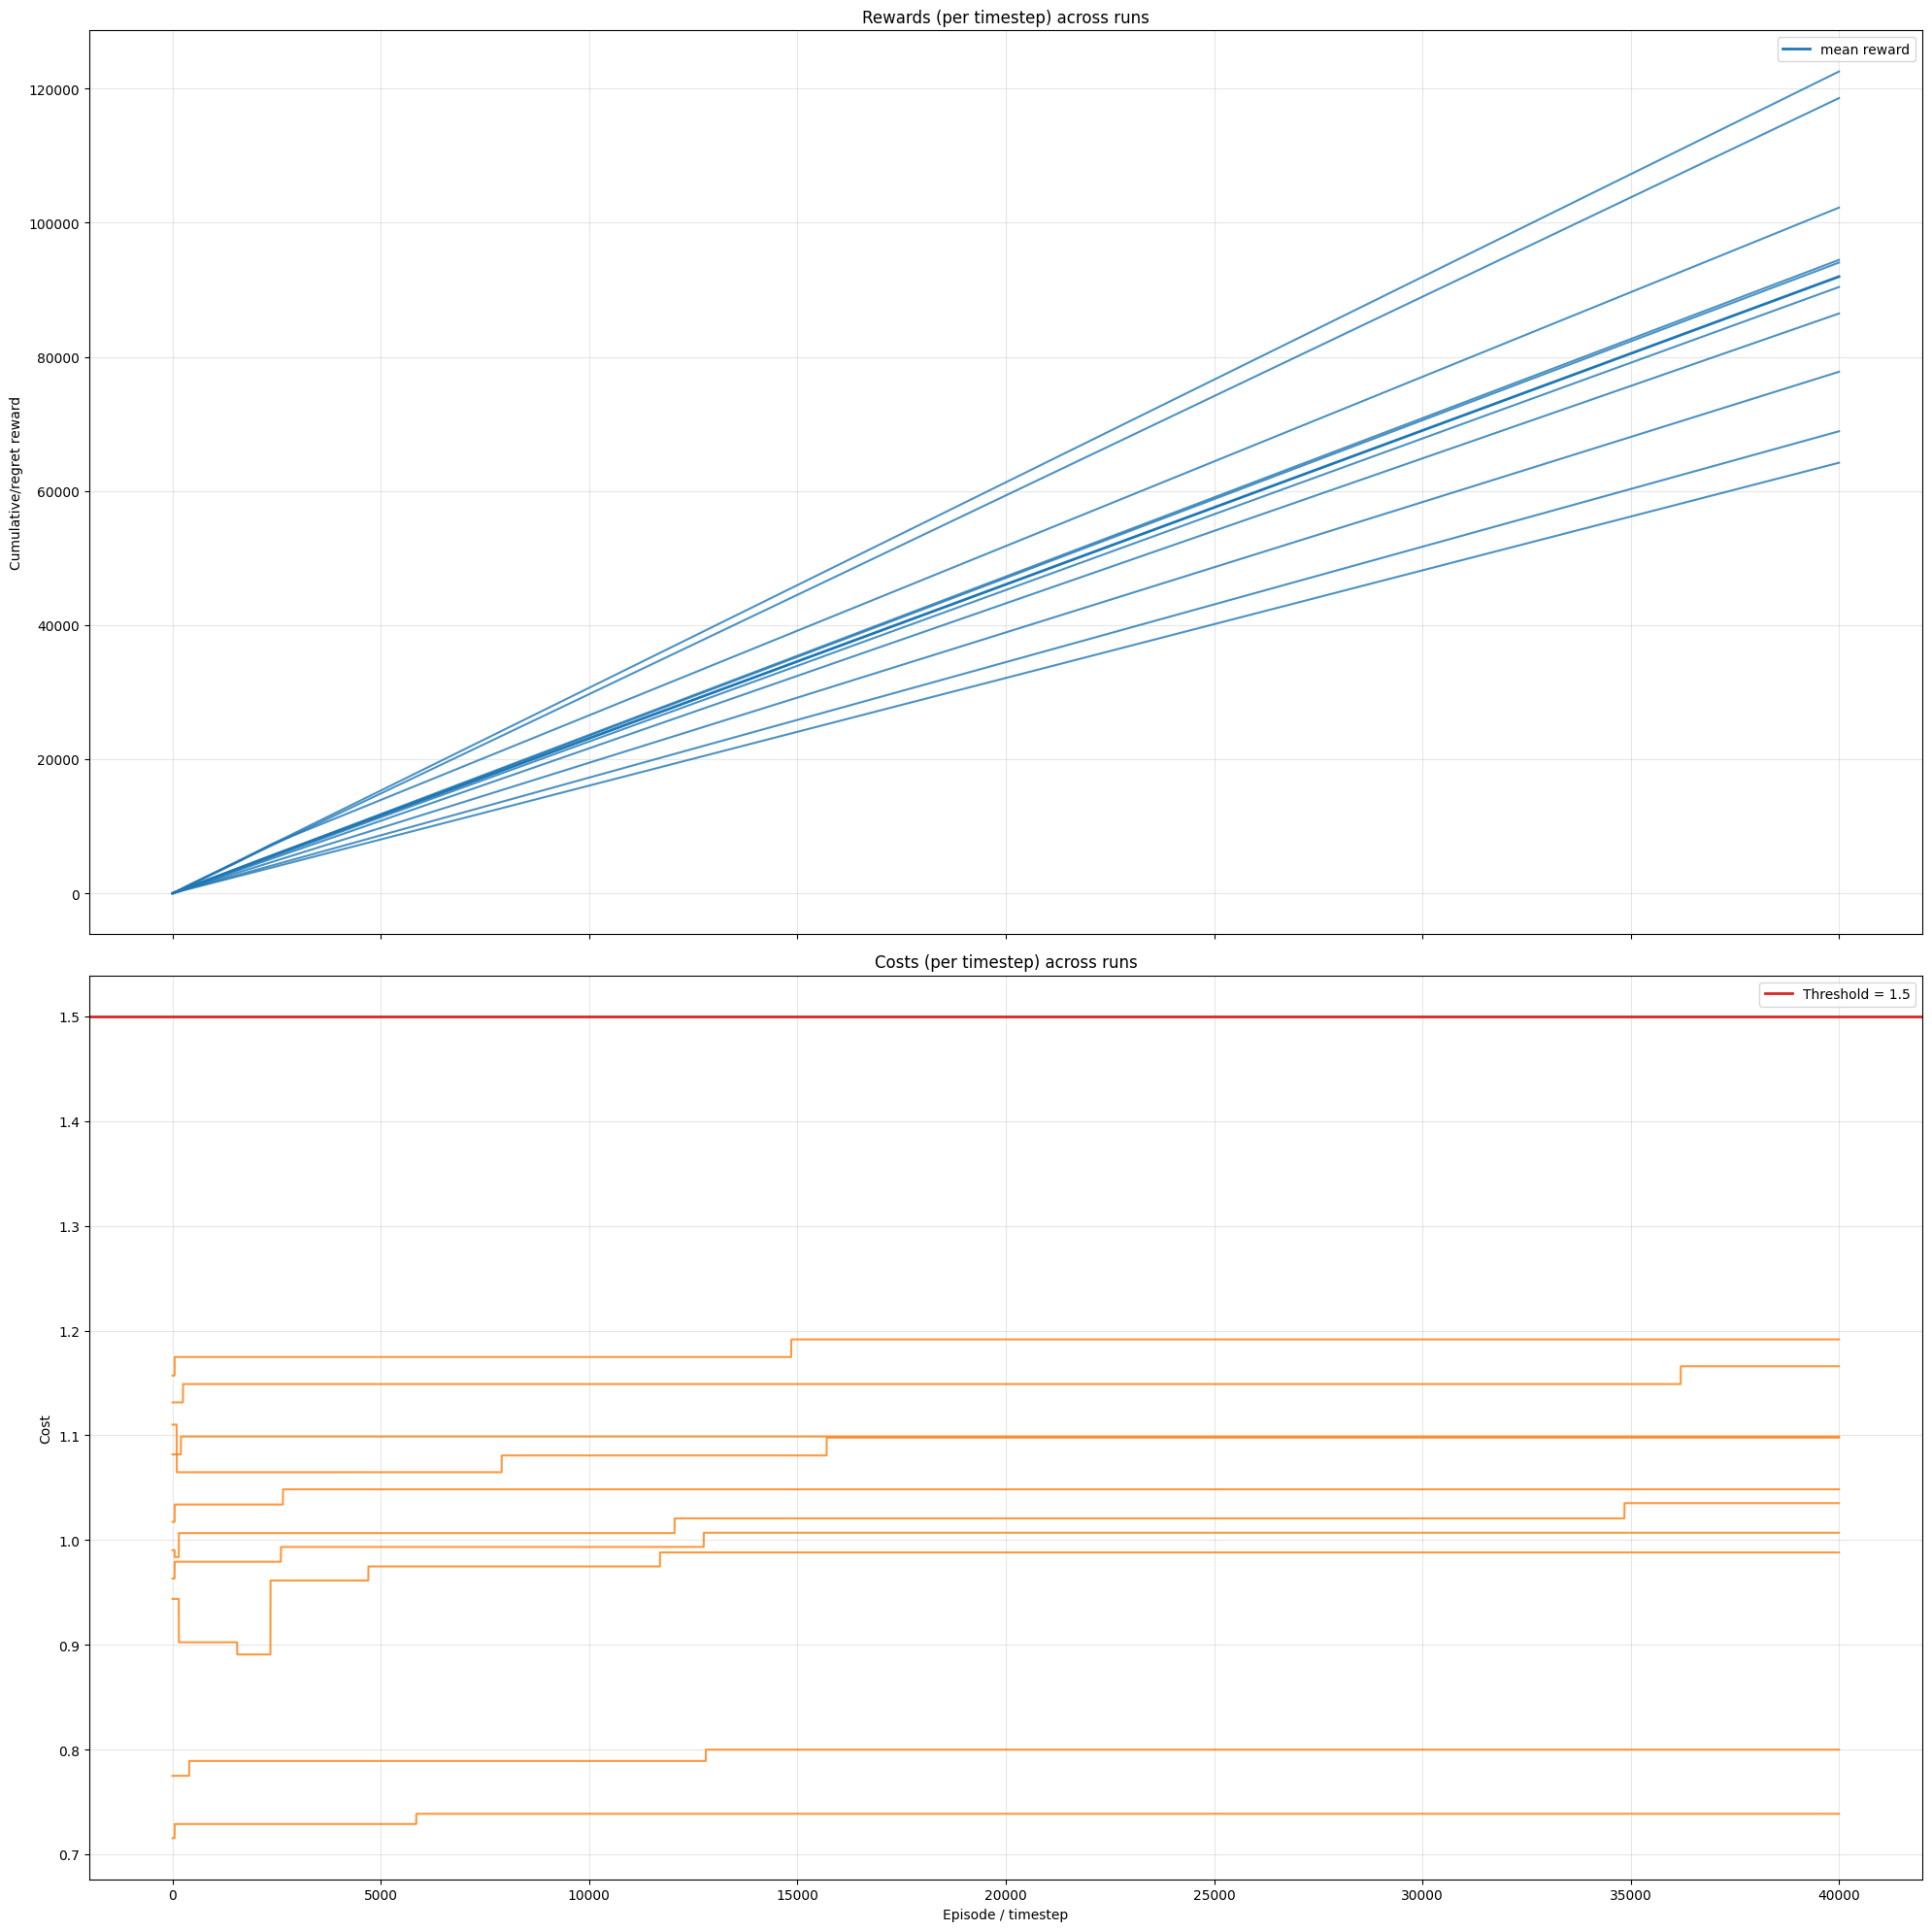

In [3]:
noise_arr = [0.33994760, 0.25363799, 0.31864008, 0.30796535, 0.33609112, 0.33084822, 0.31335413, 0.30405411, 0.34453611, 0.26760585]
# Constrauct safe policy with high entropy such that it encourages exploration for policy gradient approach
env = make_env(0.4)  
pi_s, _, _ = LP(env)
tot_e = 40000
r_meta_safe = np.zeros((len(noise_arr), tot_e))   # use tuple shape
c_meta_safe = np.zeros((len(noise_arr), tot_e)) 

for i in range(len(noise_arr)):
    noise = noise_arr[i]
    env = make_env(noise)
    r_meta_safe[i, :], c_meta_safe[i, :] = multi_step_safe_adaptation(env, pi_s, tot_e, 50)
with open("data/r_c_history_meta_safe.pkl", "wb") as f:  # Save as a pickle file
    pickle.dump({"r": r_meta_safe, "c": c_meta_safe}, f)
print("Saved r_meta_safe and c_meta_safe to data/r_c_history_meta_safe.pkl")

# Plot reward and cost histories (handles multiple runs)
n_runs, T = r_meta_safe.shape

fig, axes = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

x = np.arange(T)

# Rewards
for i in range(n_runs):
	axes[0].plot(x, r_meta_safe[i], color='C0', alpha=0.8)
axes[0].plot(x, np.mean(r_meta_safe, axis=0), color='C0', lw=2, label='mean reward')
axes[0].set_ylabel('Cumulative/regret reward')
axes[0].set_title('Rewards (per timestep) across runs')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Costs
for i in range(n_runs):
	axes[1].plot(x, c_meta_safe[i], color='C1', alpha=0.8)
axes[1].set_ylabel('Cost')
axes[1].set_xlabel('Episode / timestep')
axes[1].set_title('Costs (per timestep) across runs')
axes[1].axhline(y =  1.5, color = 'tab:red',label = 'Threshold = 1.5', linewidth=2)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("plots/reg_and_cost_meta_safe.png", format='png', dpi=800)  # Save with 800 dpi
plt.show()